In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, UnidentifiedImageError
import hashlib
from collections import defaultdict
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
base_path = 'C:\\Users\\Specter\\Desktop\\Friontier ML training\\capstone_project\\code\\data\\PlantVillage'

In [3]:
classes = os.listdir(base_path)
print("Classes available:", classes)

# Count images per class
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(base_path, cls)))} images")

Classes available: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___healthy: 152 images
Potato___Late_blight: 1000 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_healthy: 1591 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images


## Preprocessing & Data Augmentation

In [4]:
# Image dimensions
IMG_SIZE = (224, 224)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [5]:
# Set up ImageDataGenerator with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # ✅ Split 80% train / 20% val
)

In [6]:
# Create Generators for Training and Validation
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

Found 16516 images belonging to 15 classes.


In [7]:
len(train_generator.class_indices)

15

In [8]:
validation_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 4122 images belonging to 15 classes.


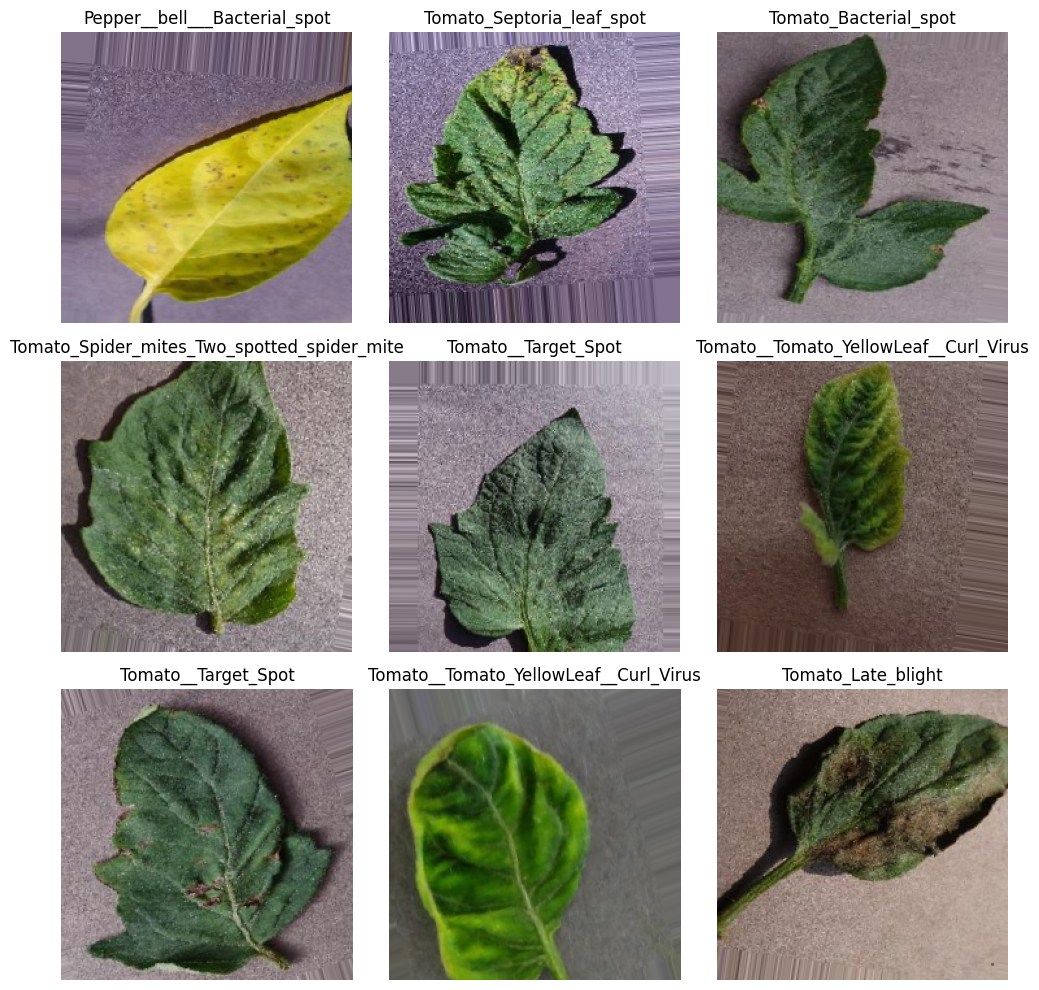

In [37]:
# Visualize a Batch of Augmented Images
images, labels = next(train_generator)

# Plot the first 9 images from the batch
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    class_label = list(train_generator.class_indices.keys())[label_index]
    plt.title(class_label)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Choose & Train an AI Model

In [38]:
# Load the Pre-trained MobileNetV2 base model (without the top classification layer)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,    
    weights='imagenet'     
)

In [39]:
# Freeze the base model 
base_model.trainable = False

# Add new classification head (custom layers)
x = base_model.output
x = GlobalAveragePooling2D()(x)           
x = Dropout(0.5)(x)                        #
output = Dense(train_generator.num_classes, activation='softmax')(x)  

In [40]:
# Create the final model
model = Model(inputs=base_model.input, outputs=output)

#  Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [41]:
# Train the model
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1041s 2s/step - accuracy: 0.4866 - loss: 1.6609 - val_accuracy: 0.8290 - val_loss: 0.5549
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1030s 2s/step - accuracy: 0.7691 - loss: 0.7040 - val_accuracy: 0.8525 - val_loss: 0.4608
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1142s 2s/step - accuracy: 0.7974 - loss: 0.5980 - val_accuracy: 0.8590 - val_loss: 0.4183
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1135s 2s/step - accuracy: 0.8065 - loss: 0.5599 - val_accuracy: 0.8772 - val_loss: 0.3764
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 805s 2s/step - accuracy: 0.8167 - loss: 0.5399 - val_accuracy: 0.8726 - val_loss: 0.3848
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 788s 2s/step - accuracy: 0.8197 - loss: 0.5407 - val_accuracy: 0.8700 - val_loss: 0.3753
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 795s 2s/step - accuracy: 0.8203 - loss: 0.5315 - val_accuracy: 0.8814 - val_loss: 0.3575
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 790s 2s/step - accuracy: 0.8254 - loss: 0.5195 - val_

In [43]:
# Plot Training & Validation Accuracy/Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

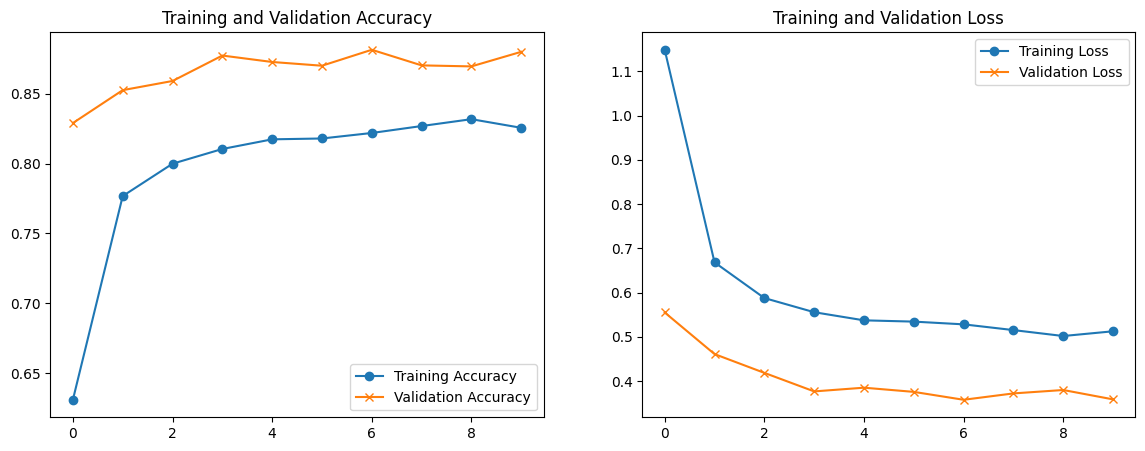

In [44]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

129/129 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step

 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.90      0.92       199
                     Pepper__bell___healthy       0.94      0.98      0.96       295
                      Potato___Early_blight       0.97      0.98      0.98       200
                       Potato___Late_blight       0.93      0.94      0.94       200
                           Potato___healthy       0.93      0.90      0.92        30
                      Tomato_Bacterial_spot       0.88      0.90      0.89       425
                        Tomato_Early_blight       0.80      0.55      0.65       200
                         Tomato_Late_blight       0.87      0.88      0.88       381
                           Tomato_Leaf_Mold       0.74      0.90      0.81       190
                  Tomato_Septoria_leaf_spot       0.88      0.79      0.83       3

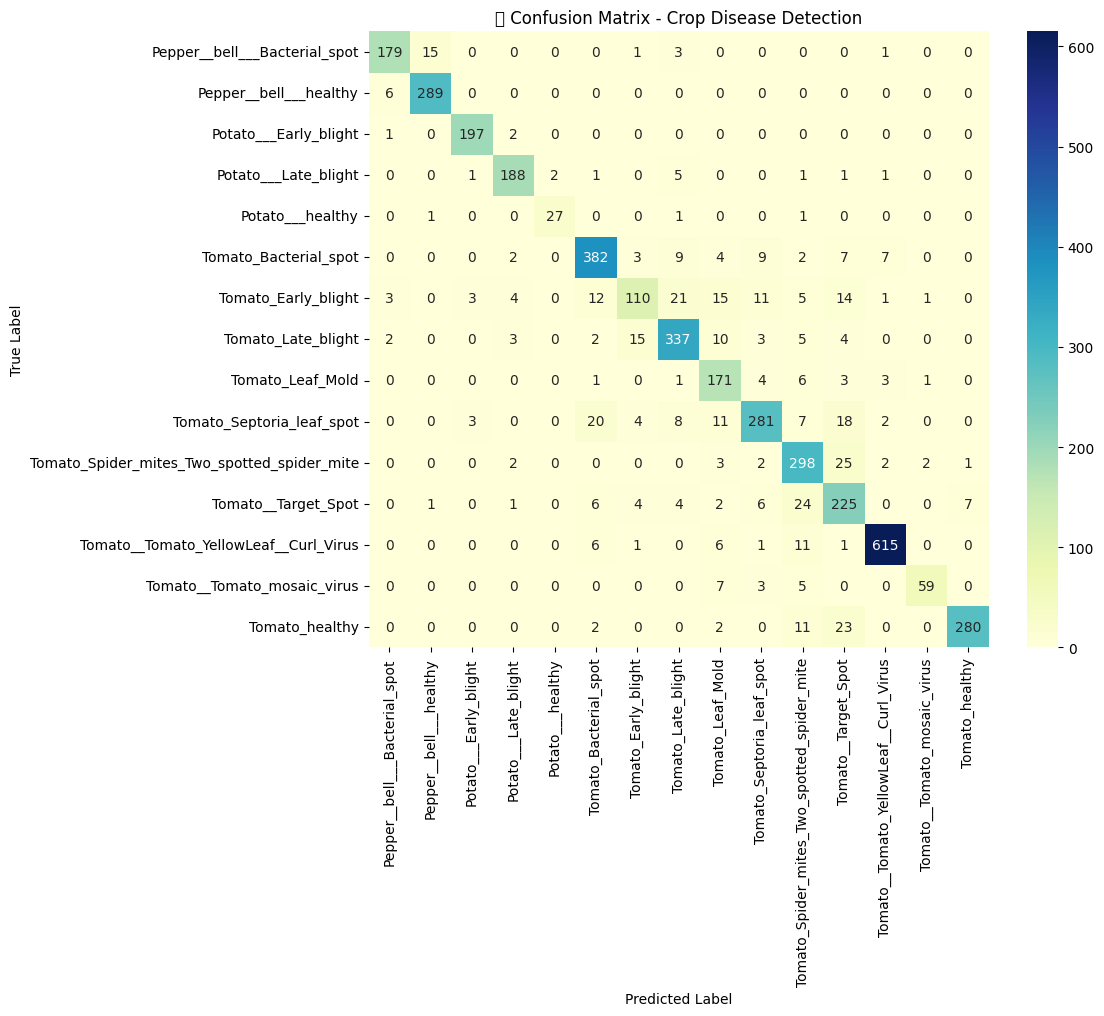

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get model predictions (probabilities)
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Print classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='YlGnBu')
plt.title('🌾 Confusion Matrix - Crop Disease Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [10]:
model.save('/plant_disease_model.h5')

NameError: name 'model' is not defined

In [ ]:
base_path

In [80]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [82]:
# Image Parameters
img_size = 224
batch_size = 32

In [83]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 16516 images belonging to 15 classes.


In [84]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 4122 images belonging to 15 classes.


In [85]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [86]:
# model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      47,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,799,247 (182.34 MB)

 Trainable params: 47,799,247 (182.34 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [88]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 2154s 4s/step - accuracy: 0.4824 - loss: 2.3665 - val_accuracy: 0.7468 - val_loss: 0.7648
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.8438 - loss: 0.4733 - val_accuracy: 0.7576 - val_loss: 0.7411
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 718s 1s/step - accuracy: 0.8514 - loss: 0.4406 - val_accuracy: 0.8494 - val_loss: 0.4414
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.9062 - loss: 0.2381 - val_accuracy: 0.8572 - val_loss: 0.4267
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 721s 1s/step - accuracy: 0.9519 - loss: 0.1506 - val_accuracy: 0.8511 - val_loss: 0.4731


In [89]:
# Model Evaluation
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 233ms/step - accuracy: 0.8510 - loss: 0.4941
Validation Accuracy: 85.03%


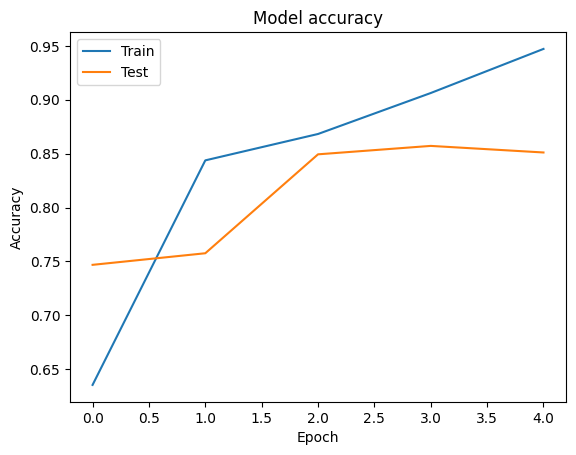

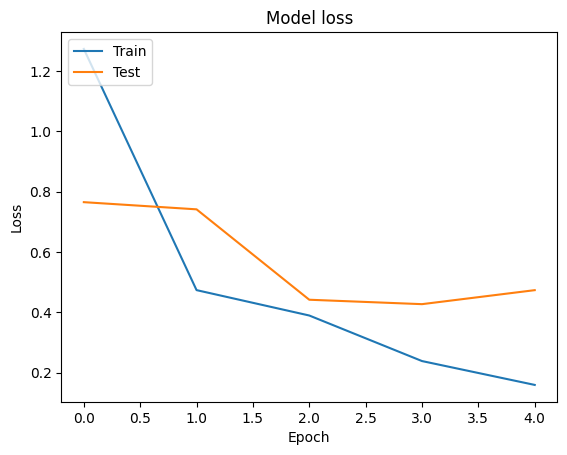

In [92]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Optimization for Mobile

In [ ]:
# Save the model
model.save('crop_disease_model.h5')

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open('crop_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite!")